# Machine learning: training

Biologists are increasingly using acoustic recorders to study species of interest. Many bioacousticians want to determine the identity of the sounds they have recorded; a variety of manual and automated methods exist for this purpose. Automated methods can make it easier and faster to quickly predict which species or sounds are in one's recordings.

Using a process called machine learning, bioacousticians can create (or "train") algorithms that can predict the identities of species vocalizing in acoustic recordings. These algorithms, called classifiers, typically do not identify sounds using the recording alone. Instead, they use image recognition techniques to identify sounds in spectrograms created from short segments of audio.

This tutorial will guide you through the process of training a simple classifier for a single species. To download the tutorial as a Jupyter Notebook and run it on your own computer, click the "Edit on GitHub" button at the top right of the tutorial. You will have to [install OpenSoundscape](installation.html#installation) to use the tutorial.

First, use the following packages to create a machine learning classifier. First, from OpenSoundscape import the following three functions (`run_command`, `binary_train_valid_split`, and `train`) and three classes (`Audio`, `Spectrogram`, and `SingleTargetAudioDataset`).

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.datasets import SingleTargetAudioDataset

from opensoundscape.helpers import run_command
from opensoundscape.data_selection import train_valid_split
from opensoundscape.torch.train import train

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [2]:
import torch
import torch.nn
import torch.optim
import torchvision.models

Lastly, use a few miscellaneous functions.

In [3]:
# For interacting with paths on the filesystem
import os.path
from pathlib import Path

# For working with dataframes, arrays, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For handling output of the training function
import io
from contextlib import redirect_stdout

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's "Raven" sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

In [4]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### Inspect the data

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

Look at the contents of `woodcock_labels.csv`. First, load them into a `pandas` DataFrame called `labels`. Use `labels.shape` to see how many audio files there are.

In [5]:
labels = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
labels.shape

(29, 3)

The above call to `labels.shape` showed that there were 29 rows and 3 columns in the loaded dataframe. Look at the `head()` of this dataframe to see the first 5 rows of its contents.

In [6]:
labels.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song



Before splitting this dataframe into training and validation sets, prepend the name of the folder in front of the filename. This allows our computer program to find these files on the filesystem during the training process.

In [7]:
labels['filename'] = 'woodcock_labeled_data' + os.path.sep + labels['filename'].astype(str)
labels.head()

,filename,woodcock,sound_type
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,present,song
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,absent,na
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,present,song
3,woodcock_labeled_data/49890077267b569e142440fa...,present,song
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,present,song


Now, use OpenSoundscape's `Spectrogram` and `Audio` classes to take a look at these files. For more information on the use of these classes, see the [tutorial](audio_and_spectrogram.html).

The first row in the `labels` dataframe contains a file with the following labels: the American Woodcock is present (`"woodcock" = "present"` and it makes a "song" in the recording (`"sound_type" = "song"`). Get the filename for this recording.

In [8]:
filename0 = labels.iloc[0]['filename']

Create a spectrogram from this file. The high-contrast signal of an American Woodcock display sound ("peent") is visible about 0.6 seconds into the recording.

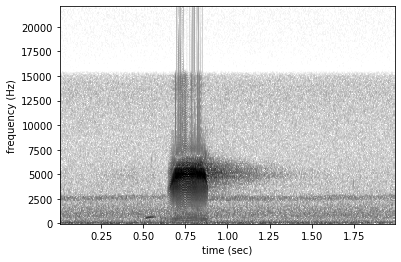

In [9]:
spect = Spectrogram.from_audio(Audio.from_file(filename0))
spect.plot()

The second file, which is marked as not having a woodcock in it (`"woodcock" = "absent"`), has no such signal:

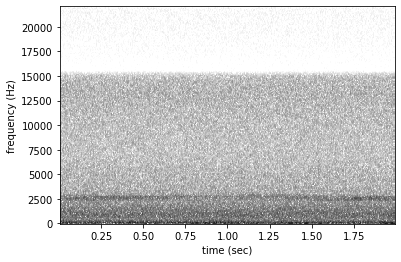

In [10]:
filename1 = labels.iloc[1]['filename']
spect = Spectrogram.from_audio(Audio.from_file(filename1))
spect.plot()

Farther below in the dataset, there are recordings labeled to contain only the "call" of a woodcock. First, list these recordings:

In [11]:
labels[labels["sound_type"] == "call"]

,filename,woodcock,sound_type
8,woodcock_labeled_data/f87d427bef752f5accbd8990...,present,call
22,woodcock_labeled_data/c057a4486b25cd638850fc07...,present,call


In reality, the "call" designation means that the woodcock only makes a short, soft, and low introductory sound, instead of the full "peent." Make a spectrogram of one of them to see the difference.

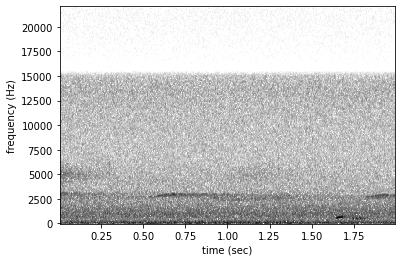

In [12]:
filename22 = labels.iloc[22]['filename']
spect = Spectrogram.from_audio(Audio.from_file(filename22))
spect.plot()

The low sound of the introductory note appears around 1000 kHz at about 1.6 seconds into the recording. Compared to the spectrogram above containing the song, this introductory note is similar to the note that comes before the loud "peent." Although in some applications the user might want to identify this call, it is probably better to mark these as "absences." The following code creates a new column just to identify whether or not the peent is present:

In [13]:
labels['woodcock_song'] = np.where(labels['sound_type']=='song', 'present', 'absent')
labels

,filename,woodcock,sound_type,woodcock_song
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,present,song,present
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,absent,na,absent
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,present,song,present
3,woodcock_labeled_data/49890077267b569e142440fa...,present,song,present
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,present,song,present
5,woodcock_labeled_data/0fc107ec5e76bf7a98dd207a...,absent,na,absent
6,woodcock_labeled_data/50b6b7c7e843597e0dbc6986...,present,song,present
7,woodcock_labeled_data/35ca80c22127c3c0ae032a08...,absent,na,absent
8,woodcock_labeled_data/f87d427bef752f5accbd8990...,present,call,absent
9,woodcock_labeled_data/0ab7732b506105717708ea95...,present,song,present


### Create numeric labels
Although the labels are currently "present" and "absent," the library used for machine learning requires numeric labels, not string labels. So, use the following code to transform the "present" and "absent" labels into 0s and 1s. First, define a mapping from the string labels to the numeric labels:

In [14]:
stringlabel_to_numbericlabel = {"absent":0, "present":1}

Next, create a new column of numeric labels:

In [15]:
labels["numeric_labels"] = labels["woodcock_song"].apply(lambda x: stringlabel_to_numbericlabel[x]) 
labels.head()

,filename,woodcock,sound_type,woodcock_song,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,present,song,present,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,absent,na,absent,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,present,song,present,1
3,woodcock_labeled_data/49890077267b569e142440fa...,present,song,present,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,present,song,present,1


Now drop the unnecessary columns of this dataset, leaving just the `"filename"` and the `"numeric_labels"` columns required to train a machine learning algorithm.

In [16]:
labels = labels[["filename", "numeric_labels"]]
labels.head()

,filename,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,1
3,woodcock_labeled_data/49890077267b569e142440fa...,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,1


In order to make it easier for future users to interpret the model results, save a dictionary that associates each numeric label with an explanatory string variable. In this case, mark the 0-labeled recordings `"scolopax-minor-absent"` and the 1-labeled recordings `"scolopax-minor-present"`. That way, as long as the model is bundled with this metadata, it will be easy to see that the `1` prediction corresponds to American Woodcock (scientific name *Scolopax minor*).

In [17]:
label_dict = {0:'scolopax-minor-absent', 1:'scolopax-minor-present'}

## Create machine learning datasets

### Training-validation split
Next, to use machine learning on these files, they must be separated into two datasets. The "training" dataset will be used to teach the machine learning algorithm. The "validation" dataset will be used to evaluate the algorithm's performance each epoch. The process of separating the data into multiple datasets is often known in machine learning as creating a "split."

Typically, machine learning practitioners use a separate validation set to check on the model's performance during and after training. While the training data are used to teach the model how to identify its focal species, the validation data are not used to teach the model. Instead, they are held out as a separate comparison. This allows us to check how well the model generalizes to data it has never seen before. A model that performs well on the training set, but very poorly on the validation set, is said to be *overfit*. Overfit models are great at identifying the original recordings they saw, but are often not useful for real applications.

First, look at the dataframe again.

In [18]:
labels.head()

,filename,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,1
3,woodcock_labeled_data/49890077267b569e142440fa...,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,1


It's often desirable to make a *stratified split*. This means that the percentage of samples in the original dataset that have each label, will be roughly equal to the percentage of each label in the training and validation datasets. So, for instance, if half of the recordings in the original dataframe had the species present, in a stratified split, half of the recordings in the training dataframe and in the validation dataframe would have the species present. 

Use a scikit-learn function to do this, specifying the `"numeric_labels"` column as the one to stratify over.

In [19]:
train_df, valid_df = train_test_split(labels, train_size=0.8, stratify=labels['numeric_labels'])

Check that the dataframes are stratified correctly. Compare the fraction of positives in the original dataset with the fraction of positives in the training and validation subsets.

In [20]:
num_samples = labels.shape[0]
num_present = sum(labels['numeric_labels'] == 1)
print(f"Fraction of original dataframe with woodcock present: {num_present/num_samples:.2f}")

Fraction of original dataframe with woodcock present: 0.69


In [21]:
num_train_samples = train_df.shape[0]
num_train_present = sum(train_df['numeric_labels'] == 1)
print(f"Fraction of train samples with woodcock present: {num_train_present/num_train_samples:.2f}")

Fraction of train samples with woodcock present: 0.70


In [22]:
num_valid_samples = valid_df.shape[0]
num_valid_present = sum(valid_df['numeric_labels'] == 1)
print(f"Fraction of train samples with woodcock present: {num_valid_present/num_valid_samples:.2f}")

Fraction of train samples with woodcock present: 0.67


So, the fraction is very close, though not exact--owing to the difference in size of these two datasets. This is not unexpected.

### Format as `SingleTargetAudioDataset`s

Turn these dataframes into "Datasets" using the `SingleTargetAudioDataset` class. Once they are set up in this class, they can be used by the training algorithm. Data augmentation could be applied in this step, but is not demonstrated here; for more information, see the [relevant API documentation](api.html#opensoundscape.datasets.SingleTargetAudioDataset).

To use this class, specify the names of the relevant columns in the dataframes:

In [23]:
train_dataset = SingleTargetAudioDataset(
    df=train_df, label_dict=label_dict, label_column='numeric_labels', filename_column='filename')
valid_dataset = SingleTargetAudioDataset(
    df=valid_df, label_dict=label_dict, label_column='numeric_labels', filename_column='filename')

## Train the machine learning model
Next, set up the architecture of the machine learning model and train it. 

### Set up model architecture
The model architecture is a neural network. Neural networks are so-named for their loose similarity to neurons. Each **neuron** takes in a small amount of data, performs a transformation to the data, and passes it on with some weight to the next neuron. Neurons are usually organized in **layers**; each neuron in one layer can be connected to one or multiple neurons in the next layer. Complex structures can arise from this series of connections.

The neural network used here is a combination of a feature extractor and a classifier. The **feature extractor** is a convolutional neural network (CNN). CNNs are a special class of neural network commonly used for image classification. They are able to interpret pixels that are near each other to identify shapes or textures in images, like lines, dots, and edges. During the training process, the CNN learns which shapes and textures are important for distinguishing between different classes.

The specific CNN used here is `resnet18`, using the `pretrained=True` option. This means that the model loaded is a version that somebody has already trained on another image dataset called ImageNet, so it has a head start on understanding features commonly seen in images. Although spectrograms aren't the same type of images as the photographs used in ImageNet, using the pretrained model will allow the model to more quickly adapt to identifying spectrograms.

In [24]:
model = torchvision.models.resnet18(pretrained = True)

Although we refer to the whole neural network as a classifier, the part of the neural network that actually does the species classification is its `fc`, or "fully connected," layers. This part of the neural network is called "fully connected" because it consists of several layers of neurons, where every neuron in each layer is connected to every other neuron in its adjacent layers.

These layers come after the CNN layers, which have already interpreted an image's features. The `fc` layers then use those interpretations to classify the image. The number of output features of the CNN, therefore, is the number of input features of the `fc` layers:

In [25]:
model.fc.in_features

512

Use a `Linear` classifier for the `fc`. To set up the `Linear` classifier, identify the input and output size for this classifier. As described above, the `fc` takes in the outputs of the feature extractor, so `in_features = model.fc.in_features`. The model identifies one species, so it has to be able to output a "present" or "absent" classification. Thus, `out_features=2`. A multi-species model would use `out_features=number_of_species`.

In [26]:
model.fc = torch.nn.Linear(in_features = model.fc.in_features, out_features = 2)

### Train the model

Next, create set up a directory in which to save results.

In [27]:
results_path = Path('model_train_results')
if not results_path.exists(): results_path.mkdir()

The scikit-learn function may throw errors when calculating metrics; the following code will silence them.

In [28]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Finally, run the model training with the following parameters:
* `save_dir`: the directory in which to save results (which is created if it doesn't exist)
* `model`: the model set up in the previous cell
* `train_dataset`: the training dataset created using `SingleTargetAudioDataset`
* `optimizer`: the optimizer to use for training the algorithm
* `loss_fn`: the loss function used to assess the algorithm's performance during training
* `epochs`: the number of times the model will run through the training data
* `log_every`: how frequently to save performance data and save intermediate machine learning weights (`log_every=1` will save every epoch)

The `train` function allows the user to control more parameters, but they are not demonstrated here. For more information, see the [train API](api.html#module-opensoundscape.torch.train).

In [41]:
float(np.array(0))/(np.array(0)+np.array(0))

<ipython-input-41-26046616b831>:1: RuntimeWarning: invalid value encountered in true_divide
  float(np.array(0))/(np.array(0)+np.array(0))


nan

In [29]:
train_outputs = io.StringIO()
with redirect_stdout(train_outputs):
    train(
        save_dir = results_path,
        model = model,
        train_dataset = train_dataset,
        valid_dataset = valid_dataset,
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3),
        loss_fn = torch.nn.CrossEntropyLoss(),
        epochs=10,
        log_every=1,
        print_logging=True,
    )

/Users/tessa/Code/opensoundscape/opensoundscape/metrics.py:104: RuntimeWarning: invalid value encountered in true_divide
  precisions[idx] = float(true_positives) / (true_positives + false_positives)
/Users/tessa/Code/opensoundscape/opensoundscape/metrics.py:104: RuntimeWarning: invalid value encountered in true_divide
  precisions[idx] = float(true_positives) / (true_positives + false_positives)
/Users/tessa/Code/opensoundscape/opensoundscape/metrics.py:104: RuntimeWarning: invalid value encountered in true_divide
  precisions[idx] = float(true_positives) / (true_positives + false_positives)
/Users/tessa/Code/opensoundscape/opensoundscape/metrics.py:104: RuntimeWarning: invalid value encountered in true_divide
  precisions[idx] = float(true_positives) / (true_positives + false_positives)
/Users/tessa/Code/opensoundscape/opensoundscape/metrics.py:104: RuntimeWarning: invalid value encountered in true_divide
  precisions[idx] = float(true_positives) / (true_positives + false_positives)


The errors produced above are due to there being both no true positives and no false positives in some steps of the training (either training or validation). They're a symptom of the small size of the training and validation datasets.

## Evaluate model performance
When training is complete, it is important to check the training results to see how well the model identifies sounds. This model was only trained on a limited amount of data, so the model is expected to not be usable--it is for demonstration purposes only.

The outputs of the training function were saved to `train_outputs`. Check out the first 100 characters of this output.

In [30]:
source_text = train_outputs.getvalue()
print(source_text[:100])

Epoch 0
  Training.
  Validating.
  Validation results:
    train_loss: 0.6376809413018434
    train


These functions help to parse the log text. They simply extract the resulting "metric" in each epoch. Metrics include accuracy, precision, recall, and f1 score.

In [31]:
def extract_all_lines_containing(source_text, str_to_extract):
    """Case-sensitive search for lines containing str_to_extract"""
    finished = False
    lines = source_text.split('\n')
    extract_lines = [line for line in lines if str_to_extract in line]
    return extract_lines

def strip_log(log, sep=':     '):
    return log.split(sep)[1].strip('[,]')

def get_metric_from_log(source_text, metric):
    all_lines_from_metric = extract_all_lines_containing(source_text, metric)
    if 'precision' in metric or 'recall' in metric:
        return [float(strip_log(line, sep=': ').strip('[]').split()[1]) for line in all_lines_from_metric]
    return [float(strip_log(line, sep=None)) for line in all_lines_from_metric]

Plot the validation accuracy each epoch. These results will look different every time the model is trained, as it is a stochastic process.

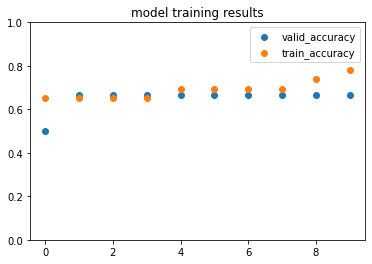

In [32]:
metrics_to_plot = ['valid_accuracy', 'train_accuracy']
fig, ax = plt.subplots(1, 1)
for metric in metrics_to_plot:
    results = get_metric_from_log(source_text, metric)
    ax.scatter(range(len(results)), results)
ax.set_ylim(0, 1)
ax.set_title('model training results')
ax.legend(metrics_to_plot)
plt.show()

Lastly, this command "cleans up" by deleting all the downloaded files and results. Only run this if you are ready to remove the results of this analysis.

In [33]:
import shutil
# Delete downloads
shutil.rmtree(Path("woodcock_labeled_data"))
# Delete results
shutil.rmtree(results_path)